## Kaggle/Dacon 필사
#### 1) Model: SVM
#### 2) Dataset: 2019~2021년 재무비율, 이자보상비율, 거시경제 지표
#### 3) 목적: 코스닥 상장 기업 중 한계기업 분류(예측)
#### 4) 필사 Code: https://dacon.io/codeshare/5525?dtype=recent (데이콘)
------------

### 0. Introduction
#### ▶ 한계기업의 정의
##### 1) 우리나라에서는 이자보상비율이 3년 연속 100% 미만인 경우에 좀비기업, 한계기업으로 칭한다. 
##### 2) 이자보상비율은 통상적으로 150% 이상일 때 이자를 지급할 수 있는 능력이 충분한 것으로 판단한다.
##### 3) 이자보상비율이 100% 미만일 때는 영업활동을 통해 얻은 이익이 매우 낮아서 이자조차 갚을 수 없다는 의미이기도 하다.
##### 4) 한계기업은 사실상 부도상태여야 하는 기업이 여러 정부 정책, 금융 상품 등으로 연명하고 있는 셈이다.
#### ▶ 이자보상비율
##### 1) 영업이익을 이자비용이나 금융비용으로 나눈 비율
##### 2) 본 분석에서는 영업이익을 이자비용으로 나눠 전처리한 데이터로 사용했다.
----------

### 1. Preprocessing

In [19]:
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve

In [96]:
from matplotlib import rc

rc('font', family='Malgun Gothic')

In [21]:
pd.set_option('mode.chained_assignment', None)

In [22]:
data = pd.read_excel('코스닥 재무비율.xlsx')

In [23]:
data.head()

,Symbol,Name,결산월,회계년,주기,ROA(영업이익)(%),ROA(세전계속사업이익)(%),ROA(당기순이익)(%),ROA(총포괄이익)(%),ROE(영업이익)(%),...,현금흐름/총자본(%),현금흐름/총자산(%),현금흐름/총차입부채(%),총자산회전율(회),자본금회전율(회),총부채회전율(회),총자본회전율(회),총부채증가율(전년동기)(%),총자산증가율(전년동기)(%),매출액증가율(전년동기)(%)
0,A091990,셀트리온헬스케어,12,2011,Annual,-1.82,-2.19,-1.92,-1.92,완전잠식,...,완전잠식,-1.9,-18.32,0.08,18.06,0.08,완전잠식,97.17,107.63,143.08
1,A091990,셀트리온헬스케어,12,2012,Annual,-3.29,-4.47,-3.4,-3.4,-21.19,...,-21.76,-3.38,-49.46,0.05,15.98,0.06,0.32,23.61,68.06,7.03
2,A091990,셀트리온헬스케어,12,2013,Annual,-1.34,-2.67,-2.09,-2.11,-6.25,...,-9.68,-2.07,-19.4,0.03,13.28,0.04,0.15,42.85,30.09,-6.04
3,A091990,셀트리온헬스케어,12,2014,Annual,N/A(IFRS),N/A(IFRS),N/A(IFRS),N/A(IFRS),N/A(IFRS),...,N/A(IFRS),N/A(IFRS),N/A(IFRS),N/A(IFRS),N/A(IFRS),N/A(IFRS),N/A(IFRS),N/A(IFRS),N/A(IFRS),N/A(IFRS)
4,A091990,셀트리온헬스케어,12,2015,Annual,5.64,6.72,-0.45,-1.82,완전잠식,...,완전잠식,-0.44,-2.66,0.25,169.76,0.23,완전잠식,-46.09,13.63,128.82


In [24]:
data.isna().sum()

Symbol                 0
Name                   0
결산월                    0
회계년                    0
주기                     0
ROA(영업이익)(%)        1853
ROA(세전계속사업이익)(%)    1853
ROA(당기순이익)(%)       1853
ROA(총포괄이익)(%)       1853
ROE(영업이익)(%)        1853
ROE(세전계속사업이익)(%)    1853
ROE(당기순이익)(%)       1853
부채비율(%)             1424
자기자본현금흐름률(%)        1853
현금흐름/영업수익(%)        1492
현금흐름/총부채(%)         1853
현금흐름/총자본(%)         1853
현금흐름/총자산(%)         1853
현금흐름/총차입부채(%)       2895
총자산회전율(회)           1853
자본금회전율(회)           1853
총부채회전율(회)           1853
총자본회전율(회)           1853
총부채증가율(전년동기)(%)     1854
총자산증가율(전년동기)(%)     1854
매출액증가율(전년동기)(%)     1922
dtype: int64

#### ▶ NA 값 대체

In [25]:
data = data.fillna(0)
data = data.replace('완전잠식', 0)
data = data.replace('N/A(IFRS)', 0)

#26개의 열 중 하나라도 0을 포함하고 있는 행과 동일한 'Name' 값을 가진 모든 행을 데이터프레임에서 제거
index_list = list()
new_index_list = list()
new_bsns_list = list()
fin_index_list = list()

for i in range(len(data['Name'])):
    bsns_list = list()
    for j in range(26):
        bsns_list.append(data.iloc[i][j])
    if 0 in bsns_list:
        new_index_list.append(data.index[i])
        new_bsns_list.append(data.iloc[i]['Name'])
for i in range(len(data['Name'])):
    if data.iloc[i]['Name'] in new_bsns_list:
        fin_index_list.append(data.index[i])
data.drop(index = fin_index_list, axis=0, inplace=True)

In [27]:
data.isna().sum()

Symbol              0
Name                0
결산월                 0
회계년                 0
주기                  0
ROA(영업이익)(%)        0
ROA(세전계속사업이익)(%)    0
ROA(당기순이익)(%)       0
ROA(총포괄이익)(%)       0
ROE(영업이익)(%)        0
ROE(세전계속사업이익)(%)    0
ROE(당기순이익)(%)       0
부채비율(%)             0
자기자본현금흐름률(%)        0
현금흐름/영업수익(%)        0
현금흐름/총부채(%)         0
현금흐름/총자본(%)         0
현금흐름/총자산(%)         0
현금흐름/총차입부채(%)       0
총자산회전율(회)           0
자본금회전율(회)           0
총부채회전율(회)           0
총자본회전율(회)           0
총부채증가율(전년동기)(%)     0
총자산증가율(전년동기)(%)     0
매출액증가율(전년동기)(%)     0
dtype: int64

In [29]:
data1 = pd.read_excel('이자보상비율.xlsx')

In [30]:
data1.head()

,Symbol,Name,결산월,회계년,주기,영업이익(천원),이자비용(천원)
0,A091990,셀트리온헬스케어,12,2011,Annual,-6836551.0,0.0
1,A091990,셀트리온헬스케어,12,2012,Annual,-22371465.0,10270101.0
2,A091990,셀트리온헬스케어,12,2013,Annual,-13108668.0,6423470.0
3,A091990,셀트리온헬스케어,12,2014,Annual,35849137.0,34969000.0
4,A091990,셀트리온헬스케어,12,2015,Annual,84332048.0,56467000.0


In [32]:
data1.describe()

,결산월,회계년,영업이익(천원),이자비용(천원)
count,16555.000000,16555.000000,1.512500e+04,1.512500e+04
mean,11.836484,2016.000000,7.672210e+06,1.584301e+06
std,1.111691,3.162373,2.911655e+07,6.054155e+06
min,2.000000,2011.000000,-1.010184e+08,0.000000e+00
25%,12.000000,2013.000000,-1.827169e+05,1.358400e+04
50%,12.000000,2016.000000,2.835067e+06,3.381408e+05
75%,12.000000,2019.000000,8.773584e+06,1.324588e+06
max,12.000000,2021.000000,1.315452e+09,2.416738e+08


In [33]:
#영업이익이나 이자비용의 데이터가 0인 회사 전체를 삭제
bsns_list = list()
index_list = list()
for i in range(len(data1['Name'])):
  if data1['영업이익(천원)'][i] == 0 or data1['이자비용(천원)'][i] == 0:
    bsns_list.append(data1['Name'][i])
for i in range(len(data1['Name'])):
  if data1['Name'][i] in bsns_list:
    index_list.append(i)
data1.drop(index = index_list, axis = 0, inplace = True)

In [34]:
#이자보상비율, 한계기업 컬럼 추가
data1['이자보상비율'] = data1['영업이익(천원)']/data1['이자비용(천원)']
bsns_set = list()
for i in range(len(data1['Name'])):
    bsns_set.append(data1.iloc[i]['Name'])
data1['한계기업']=0

In [35]:
bsns_set = set(bsns_set)
bsns_set1 = list(bsns_set)
index = [x for x in range(8481)]
data1['index'] = index
data1.set_index(['index'], inplace=True)

In [36]:
#이자보상비율이 3년 연속 1 미만인 기업은 한계기업(1), 아니면 정상기업(0)
data2 = data1[['Name', '회계년', '이자보상비율', '한계기업']]
for i in range(len(data2)-2):
    for j in range(9):
        if data2['이자보상비율'][i] < 1:
            if data2['이자보상비율'][i+1] < 1:
                if data2['이자보상비율'][i+2] < 1:
                    data1['한계기업'][i+2] = 1

In [37]:
final_df = pd.merge(data, data1)
final_df

,Symbol,Name,결산월,회계년,주기,ROA(영업이익)(%),ROA(세전계속사업이익)(%),ROA(당기순이익)(%),ROA(총포괄이익)(%),ROE(영업이익)(%),...,자본금회전율(회),총부채회전율(회),총자본회전율(회),총부채증가율(전년동기)(%),총자산증가율(전년동기)(%),매출액증가율(전년동기)(%),영업이익(천원),이자비용(천원),이자보상비율,한계기업
0,A028300,HLB,12,2011,Annual,4.39,-1.81,-12.68,-12.70,11.30,...,7.64,1.93,3.04,-15.31,-14.69,55.19,2585133.21,3131453.00,0.825538,0
1,A028300,HLB,12,2012,Annual,-5.60,-12.47,-16.58,-16.57,-13.65,...,5.01,1.68,2.41,-14.11,-7.87,-25.71,-2918963.62,2070350.00,-1.409889,0
2,A028300,HLB,12,2013,Annual,-12.43,-20.94,-25.04,-24.85,-28.85,...,1.76,0.85,1.12,-27.45,-27.77,-59.71,-5349857.53,1133278.00,-4.720693,1
3,A028300,HLB,12,2014,Annual,0.80,-3.98,-7.19,-7.17,1.88,...,2.82,1.43,1.93,51.60,50.27,78.71,362177.86,1944280.00,0.186279,1
4,A028300,HLB,12,2015,Annual,-4.98,8.83,8.73,9.10,-8.68,...,2.46,0.75,0.56,126.64,241.32,3.43,-5963200.40,2840486.00,-2.099359,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5297,A058450,일야,12,2017,Annual,-8.44,-12.41,-13.00,-13.14,-13.32,...,8.75,3.18,1.83,-18.92,-18.84,-42.08,-3106233.95,107061.12,-29.013651,0
5298,A058450,일야,12,2018,Annual,-12.40,-33.65,-34.27,-34.69,-24.18,...,4.48,1.74,1.65,74.01,5.77,-32.8,-4206325.44,254516.82,-16.526709,0
5299,A058450,일야,12,2019,Annual,-0.34,-3.42,-8.50,-8.27,-1.08,...,0.31,0.09,0.20,58.14,25.66,-91.57,-132941.40,278112.37,-0.478013,1
5300,A058450,일야,12,2020,Annual,-4.79,-4.57,-20.46,-20.62,-16.05,...,0.68,0.26,0.61,-12.90,1.93,232.19,-2117091.78,486758.69,-4.349366,1


In [54]:
indicator = pd.read_excel('거시지표.xlsx')

In [55]:
indicator.head()

,Unnamed: 0,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,국고채 3년(평균)-%,3.62,3.130,2.79,2.590,1.790,1.440,1.800,2.100,1.530,0.99,1.39
1,경상수지(백만불)-값,16638.00,48791.000,77259.00,83030.000,105119.000,97924.000,75231.000,77467.000,59376.000,75902.00,88302.00
2,소비자물가지수(CPI)-값,89.85,91.815,93.01,94.196,94.861,95.783,97.645,99.086,99.466,100.00,102.50
3,실업률(15세 이상)-%,3.40,3.200,3.10,3.500,3.600,3.700,3.700,3.800,3.800,4.00,3.70
4,코스닥 지수(연월말)-값,500.00,496.320,499.99,542.970,682.350,631.440,798.420,675.650,669.830,968.42,1033.98


In [56]:
indicator.isna().sum()

Unnamed: 0    0
2011          0
2012          0
2013          0
2014          0
2015          0
2016          0
2017          0
2018          0
2019          0
2020          0
2021          0
dtype: int64

In [57]:
indicator1 = indicator.T
indicator_list = ['국고채 3년(평균)-%', '경상수지(백만불)-값','소비자물가지수(CPI)-값', '실업률(15세 이상)-%', '코스닥 지수(연월말)-값', '환율-값', 'WTI등락률-%', '국내총생산(명목GDP)']
indicator1.columns = indicator_list
indicator1.drop(['Unnamed: 0'], axis=0, inplace=True)

In [58]:
# 각 컬럼 초기화
for col in indicator_list:
    final_df[col] = float(0)

# 각 연도에 해당하는 거시경제 지표 추가
for i in range(len(final_df['Name'])):
    for j in range(len(indicator_list)):
        indicator = indicator_list[j]
        year = final_df['회계년'][i]
        # 연도에 해당하는 인덱스 계산 (2011년은 0, 2012년은 1, ...)
        year_index = year - 2011
        
        if year_index >= 0 and year_index < len(indicator1[indicator]):
            final_df.loc[i, indicator] = indicator1[indicator].iloc[year_index]

In [59]:
#'적전', '흑전'과 같은 단어가 들어가있는 기업을 삭제
index_list = list()
for i in range(len(final_df['Name'])):
  if final_df['Name'][i] == '큐캐피탈' or final_df['Name'][i] == '한국캐피탈':
    index_list.append(i)
final_df.drop(index = index_list, axis = 0, inplace = True)

In [60]:
#사용할 데이터 프레임(각 기업의 2011~2021 재무비율과 거시경제 지표)
index = [x for x in range(len(final_df))]
final_df['index'] = index
final_df = final_df.set_index('index')
final_df

,Symbol,Name,결산월,회계년,주기,ROA(영업이익)(%),ROA(세전계속사업이익)(%),ROA(당기순이익)(%),ROA(총포괄이익)(%),ROE(영업이익)(%),...,이자보상비율,한계기업,국고채 3년(평균)-%,경상수지(백만불)-값,소비자물가지수(CPI)-값,실업률(15세 이상)-%,코스닥 지수(연월말)-값,환율-값,WTI등락률-%,국내총생산(명목GDP)
index,,,,,,,,,,,,,,,,,,,,,
0,A028300,HLB,12,2011,Annual,4.39,-1.81,-12.68,-12.70,11.30,...,0.825538,0,3.62,16638.0,89.850,3.4,500.00,1159.25,0.081528,1388937.2
1,A028300,HLB,12,2012,Annual,-5.60,-12.47,-16.58,-16.57,-13.65,...,-1.409889,0,3.13,48791.0,91.815,3.2,496.32,1063.64,-0.070930,1440111.4
2,A028300,HLB,12,2013,Annual,-12.43,-20.94,-25.04,-24.85,-28.85,...,-4.720693,1,2.79,77259.0,93.010,3.1,499.99,1049.50,0.071900,1500819.1
3,A028300,HLB,12,2014,Annual,0.80,-3.98,-7.19,-7.17,1.88,...,0.186279,1,2.59,83030.0,94.196,3.5,542.97,1092.90,-0.459700,1562928.9
4,A028300,HLB,12,2015,Annual,-4.98,8.83,8.73,9.10,-8.68,...,-2.099359,1,1.79,105119.0,94.861,3.6,682.35,1174.95,-0.304700,1658020.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,A058450,일야,12,2017,Annual,-8.44,-12.41,-13.00,-13.14,-13.32,...,-29.013651,0,1.80,75231.0,97.645,3.7,798.42,1066.37,0.124700,1835698.2
5276,A058450,일야,12,2018,Annual,-12.40,-33.65,-34.27,-34.69,-24.18,...,-16.526709,0,2.10,77467.0,99.086,3.8,675.65,1113.30,-0.248700,1898192.6
5277,A058450,일야,12,2019,Annual,-0.34,-3.42,-8.50,-8.27,-1.08,...,-0.478013,1,1.53,59376.0,99.466,3.8,669.83,1154.07,0.344600,1924498.1


In [61]:
f_bsns_list = list()
for i in range(len(final_df['Name'])):
    f_bsns_list.append(final_df['Name'][i])
len(set(f_bsns_list))

480

In [62]:
#회사 각각만을 추출하여 'df_회사명'이라는 이름으로 데이터프레임을 만들기
company_box = []
for i in range(len(f_bsns_list)):
    globals()['df_{}'.format(f_bsns_list[i])] = final_df[final_df['Name'] == f_bsns_list[i]]
    globals()['df_{}'.format(f_bsns_list[i])].drop(['Symbol', '결산월', '회계년', '주기', 'Name', '영업이익(천원)', '이자비용(천원)', '이자보상비율'], axis = 1, inplace = True)
    globals()['df1_{}'.format(f_bsns_list[i])] = globals()['df_{}'.format(f_bsns_list[i])].copy()

In [63]:
final_df.drop(['Symbol', 'Name', '결산월', '회계년', '주기',  '영업이익(천원)', '이자비용(천원)', '이자보상비율'], axis=1, inplace=True)

In [64]:
company_name_box = pd.unique(f_bsns_list)
for i in company_name_box:
    company_box.append('df_{}'.format(i))

In [66]:
#위에서 만든 df_회사명을 넣으면 88개 열을 가진 df로 만들어주는 함수
def year_make(df_raw):
    df = df_raw.copy()
    column_name = list()
    
    for i in range(len(df_raw.columns)):
        if df_raw.columns[i] != '한계기업':
            for j in range(1, 4):
                column_name.append(df_raw.columns[i] + '{}'.format(j))
        else:
            column_name.append(df_raw.columns[i])

    for i in range(len(column_name)):
        new_index = column_name[i]
        df[new_index] = 0

    for i in range(len(df.columns)):
        if df.columns[i][-1] == '1':
            new_list = list(df_raw[df.columns[i][:-1]][:8])
            new_list.append(0)
            new_list.append(0)
            new_list.append(0)
            df[df.columns[i]] = new_list
        elif df.columns[i][-1] == '2':
            new_list = list(df_raw[df.columns[i][:-1]][1:9])
            new_list.append(0)
            new_list.append(0)
            new_list.append(0)
            df[df.columns[i]] = new_list
        elif df.columns[i][-1] == '3':
            new_list = list(df_raw[df.columns[i][:-1]][2:10])
            new_list.append(0)
            new_list.append(0)
            new_list.append(0)
            df[df.columns[i]] = new_list
        elif df.columns[i] == '한계기업':
            new_list = list(df_raw[df.columns[i]][3:])
            new_list.append(0)
            new_list.append(0)
            new_list.append(0)
            df[df.columns[i]] = new_list            
    df_raw_drop = df_raw.drop(['한계기업'], axis = 1, inplace = False)
    df_drop = df.drop(columns = df_raw_drop.columns, axis = 1)
    df_drop = df_drop.iloc[:7]
    return df_drop

In [68]:
#루프의 진행상황 표시
from tqdm import tqdm

final = pd.DataFrame()
for i in tqdm(range(len(company_name_box))):
    ls = year_make(globals()['df_{}'.format(company_name_box[i])])
    final = pd.concat([final, ls], axis = 0)
    pass

100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [00:35<00:00, 13.59it/s]


In [69]:
final

,한계기업,ROA(영업이익)(%)1,ROA(영업이익)(%)2,ROA(영업이익)(%)3,ROA(세전계속사업이익)(%)1,ROA(세전계속사업이익)(%)2,ROA(세전계속사업이익)(%)3,ROA(당기순이익)(%)1,ROA(당기순이익)(%)2,ROA(당기순이익)(%)3,...,코스닥 지수(연월말)-값3,환율-값1,환율-값2,환율-값3,WTI등락률-%1,WTI등락률-%2,WTI등락률-%3,국내총생산(명목GDP)1,국내총생산(명목GDP)2,국내총생산(명목GDP)3
index,,,,,,,,,,,,,,,,,,,,,
0,1,4.39,-5.60,-12.43,-1.81,-12.47,-20.94,-12.68,-16.58,-25.04,...,499.99,1159.25,1063.64,1049.50,0.081528,-0.07093,0.0719,1388937.2,1440111.4,1500819.1
1,1,-5.60,-12.43,0.80,-12.47,-20.94,-3.98,-16.58,-25.04,-7.19,...,542.97,1063.64,1049.50,1092.90,-0.070930,0.07190,-0.4597,1440111.4,1500819.1,1562928.9
2,1,-12.43,0.80,-4.98,-20.94,-3.98,8.83,-25.04,-7.19,8.73,...,682.35,1049.50,1092.90,1174.95,0.071900,-0.45970,-0.3047,1500819.1,1562928.9,1658020.4
3,1,0.80,-4.98,-11.30,-3.98,8.83,-12.50,-7.19,8.73,-12.50,...,631.44,1092.90,1174.95,1206.25,-0.459700,-0.30470,0.4505,1562928.9,1658020.4,1740779.6
4,1,-4.98,-11.30,-13.93,8.83,-12.50,-17.79,8.73,-12.50,-11.38,...,798.42,1174.95,1206.25,1066.37,-0.304700,0.45050,0.1247,1658020.4,1740779.6,1835698.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5271,0,3.39,12.53,9.20,4.35,8.50,5.17,3.87,7.98,7.14,...,682.35,1049.50,1092.90,1174.95,0.071900,-0.45970,-0.3047,1500819.1,1562928.9,1658020.4
5272,0,12.53,9.20,6.61,8.50,5.17,3.76,7.98,7.14,5.32,...,631.44,1092.90,1174.95,1206.25,-0.459700,-0.30470,0.4505,1562928.9,1658020.4,1740779.6
5273,0,9.20,6.61,-8.44,5.17,3.76,-12.41,7.14,5.32,-13.00,...,798.42,1174.95,1206.25,1066.37,-0.304700,0.45050,0.1247,1658020.4,1740779.6,1835698.2


In [70]:
#한계기업과 정상기업 수 확인
final_1 = final[final['한계기업']==1]
final_0 = final[final['한계기업']==0]
final_index = list()
for i in final_0.index:
    final_index.append(i)

In [76]:
final_1['한계기업'].count(), final_0['한계기업'].count()

(493, 2867)

In [77]:
#한계기업 수 만큼 정상기업 무작위로 추출
final_0_random = random.sample(final_index, 493)
final_0_random1 = final_0.loc[final_0_random]

In [78]:
random_df = pd.concat([final_0_random1, final_1])

#### ▶ 표준화/정규화

In [80]:
feature_columns = list(random_df.columns.difference(['한계기업']))
standard = StandardScaler()
standard.fit(random_df[feature_columns])
standard_data = standard.transform(random_df[feature_columns])
scaler = MinMaxScaler()
scaler.fit(standard_data)
final_data = scaler.transform(standard_data)

#### ▶ 데이터 셋 분리

In [82]:
x = final_data
y = random_df['한계기업']
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(788, 87) (198, 87) (788,) (198,)


------------
### 2. Modeling

#### ▶ SVM(Support Vector Machine)
##### 1) 고차원 데이터의 분류 문제에 좋은 성능을 보이는 모델
##### 2) guadratic programming(2차 방정식) 문제로 formulation
##### 3) 다른 모델은 training generaliztion ability와 testing generaliztion ability이 trade-off 관계지만,
#####  &nbsp; SVM은 training error를 줄이는 방향으로 만들면, testing error도 자연스럽게 줄어들어드는 모델
##### 4) linear SVM, RBF SVM

In [83]:
svm_clf = svm.SVC(kernel = 'linear')
scores = cross_val_score(svm_clf, x, y, cv=5)
scores

array([0.86363636, 0.81725888, 0.85786802, 0.88832487, 0.86294416])

In [84]:
pd.DataFrame(cross_validate(svm_clf, x, y, cv=5))
print('교차검증 평균:', scores.mean())

교차검증 평균: 0.8580064605445316


In [86]:
svm_clf = svm.SVC(kernel ='rbf', probability=False)
scores = cross_val_score(svm_clf, x, y, cv=5)
scores

pd.DataFrame(cross_validate(svm_clf, x, y, cv=5))
print('교차검증 평균:', scores.mean())

교차검증 평균: 0.8336717428087986


In [88]:
x = final_data
y = random_df['한계기업']

#liner가 더 성능 좋으므로 linear로 선형분리
svm_clf = svm.SVC(kernel='linear', random_state=42, probability=True)
svm_clf.fit(train_x, train_y)
svm_pred = svm_clf.predict(test_x)

scores = cross_val_score(svm_clf, x, y, cv=10)
scores

pd.DataFrame(cross_validate(svm_clf, x, y, cv=10))
print('교차검증 평균:', scores.mean())

교차검증 평균: 0.8590702947845805


In [93]:
from sklearn.metrics import confusion_matrix

#예측 모델에 대한 혼동 행렬(cross validation)을 데이터프레임 형태로 출력해주는 함수
def conf_matrix(method):
    methods = ['rf', 'xgb', 'svm', 'dnn']
    if method in methods:
        method_pred = globals()['{}'.format(method)+'_pred']
    conf_matrix = confusion_matrix(test_y, method_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix)
    conf_matrix_df.columns = ['정상기업', '한계기업']
    conf_matrix_df.index = ['정상기업', '한계기업']
  
    
    m_precision_score = precision_score(test_y, method_pred)
    m_recall_score = recall_score(test_y, method_pred)
    m_accuracy_score = accuracy_score(test_y, method_pred)
    m_F1_score = f1_score(test_y, method_pred)

    # print('{} Precision: {}'.format(method, m_precision_score))
    # print('{} Recall: {}'.format(method, m_recall_score))
    # print('{} Accuracy: {}'.format(method, m_accuracy_score))
    # print('{} F1 Score: {}'.format(method, m_F1_score))
    globals()['{}_list'.format(method)] = [m_precision_score, m_recall_score, m_accuracy_score, m_F1_score]

    return conf_matrix_df
  
conf_matrix('svm')

,정상기업,한계기업
정상기업,84,15
한계기업,10,89


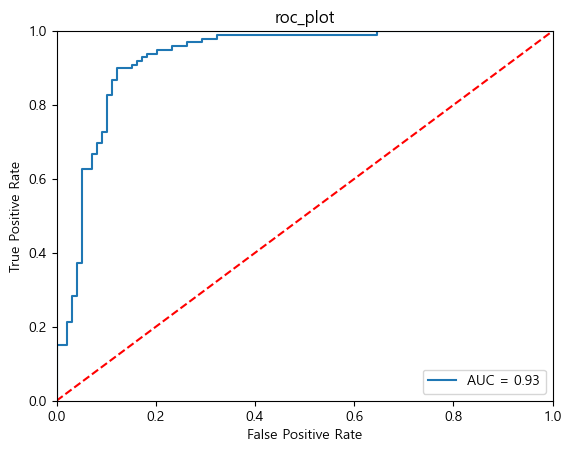

In [97]:
import sklearn.metrics as metrics
prob_model = 0

#예측 모델에 대한 ROC 곡선(ROC Curve)을 출력해주는 함수
def roc_plot(model):
    if model == prob_model:
        preds = prob_model.predict(test_x).ravel()
    else:
        probs = model.predict_proba(test_x)
        preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(test_y, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('roc_plot')
    plt.plot(fpr, tpr, '', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
roc_plot(svm_clf)